<a href="https://colab.research.google.com/github/polortiz4/Smart-Cameras/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demosaicking Homework
## Pablo Ortiz
### 02/13/19

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
import re
from time import gmtime, strftime, sleep
import subprocess
import os
import importlib
import urllib.request
import pickle

from keras import backend as K
from keras.models import Model, load_model 
from keras.layers import Reshape, Multiply, UpSampling2D, Add, Concatenate, Input, Lambda, Conv2D, Dense
import tensorflow as tf

%matplotlib inline

/Users/pabloortiz/anaconda/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
Using TensorFlow backend.


In [2]:
mpl.rcParams['figure.figsize'] = (16.0, 8.0)

The values below are taken from the paper

In [3]:
batch_size = 64
epochs = 20
W = 64 # Filters per Layer
D = 15 # Layers
k = 3 # Kernel size

# PART 1: Capture Raw Bayer images and display/compare their patter

In [4]:
def grabImage(sid = 1, imres = 8, cameraIP = '10.236.176.38'):
    cmdA = 'ssh -i ~/.ssh/id_rsa_nopassword nvidia@' + cameraIP # Run a command in the DISP camera
    cmdB = 'scp -i ~/.ssh/id_rsa_nopassword nvidia@' + cameraIP # Copy a file from the DISP camera
    
    cmdD = ' "nvgstcapture-1.0 -m 1 --sensor-id ' + str(sid) + ' -A --capture-auto 1 --dump-bayer \
    --file-name dbGrab --image-res ' + str(imres) + '"'
    
    subprocess.run('bash -c ' + "'rm dbGrab*'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c '+"'rm *.raw'", stdout = subprocess.PIPE, shell = True)
    
    subprocess.run('bash -c ' + "'" + cmdA +' "rm dbGrab*"' + "'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c ' + "'" + cmdA + ' "rm *.raw"' + "'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c ' + "'" + cmdA + cmdD + "'", stdout = subprocess.PIPE, shell = True)
    
    subprocess.run('bash -c ' + "'" + cmdB + ':dbGrab* .' + "'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c ' + "'" + cmdB + ':*.raw .' + "'", stdout = subprocess.PIPE, shell = True)
    
    # Clean the camera
    subprocess.run('bash -c ' + "'" + cmdA +' "rm dbGrab*"' + "'", stdout = subprocess.PIPE, shell = True)
    subprocess.run('bash -c ' + "'" + cmdA + ' "rm *.raw"' + "'", stdout = subprocess.PIPE, shell = True)
    
    pop = subprocess.run("bash -c 'ls'", stdout = subprocess.PIPE, shell = True)
    rePop = pop.stdout
    rePop = rePop.decode('utf-8')
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName = fileName.group()
    jIm = imio.imread(fileName)
    
    fileName = re.search(r'(.*).raw', rePop)
    fileName = fileName.group()
    rIm = np.fromfile(fileName, dtype = np.dtype('i2'))
    rows = 2190
    runL = 3864
    rIm = np.reshape(rIm[:rows * runL], (rows, runL))
    rIm = np.rot90(rIm, 2)
    
    return [jIm, rIm]


The following cell is written to have flexibility in terms of running the code in a Colab GPU and my laptop: the Google Colab computers are not connected to Duke network and therefore have no access to the camera in the DISP. For this, what we can do is manually upload the image to the file in the Colab computer

In [5]:
def upload_files():
  from google.colab import files # This will only run if the notebook is ran in colab
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

First, we verify if we are in a google colab computer. I make the distinction under the assumption that my non-colab computer does not have the module google.colab installed

In [6]:
spam_loader = importlib.util.find_spec('google.colab')
if spam_loader is not None: # Equivalent to: Is this a Colab session?
    '''
    Confirmed that we are inside a google colab environment
    Now we want to look for the image. If the image is already in the Files, just read it. 
    If not, have user upload.
    '''
    pop = subprocess.run("bash -c 'ls'", stdout = subprocess.PIPE, shell = True)
    rePop = pop.stdout
    rePop = rePop.decode('utf-8')
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    if fileName is None:
        upload_files() # Upload dbGrag jpg
        upload_files() # Upload nvgs raw
        pop = subprocess.run("bash -c 'ls'", stdout = subprocess.PIPE, shell = True)
        rePop = pop.stdout
        rePop = rePop.decode('utf-8')
        fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName = fileName.group()
    jIm = imio.imread(fileName)

    fileName = re.search(r'(.*).raw', rePop)
    fileName = fileName.group()
    rIm = np.fromfile(fileName, dtype = np.dtype('i2'))
    rows = 2190
    runL = 3864
    rIm = np.reshape(rIm[:rows * runL], (rows, runL))
    rIm = np.rot90(rIm, 2)
else:
    jIm, rIm = grabImage(sid = 0, imres = 8)
        

## Extract the RGB Color Planes

First, we want to analyze the captured image to see where how the Bayer pattern is places. (is it GBGR, BGGR, RGGB, or RGBG?)

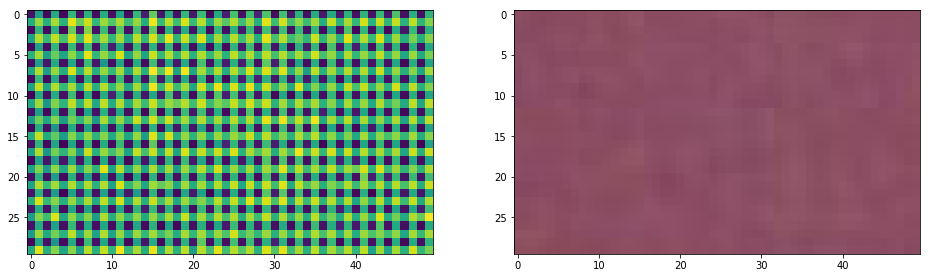

In [7]:
plt.subplot(1,2,1)
plt.imshow(rIm[20:50, :50])
plt.subplot(1,2,2)
plt.imshow(jIm[20:50, :50])
# plt.imshow(rIm[1600:1750,1300:1400])

From close analysis of these pixels in the raw data and compared to the jpeg image, we can observe that the pattern is BGGR. That is because the pixels in the fourth quadrant are brighter than the other ones suggesting they are the red ones. You can tell which are the blue pixels by observing the dim pixels are spaced out as opposed to patterned in diagonals. 

In [8]:
green1 = rIm[1::2, ::2] 
green2 = rIm[::2, 1::2] 
red = rIm[1::2, 1::2] 
blue = rIm[::2, ::2] 

To verify that the channels were extracted correctly, we zoom in to the color markers and observe if the channels correspond to their respective colors (each color channel should show it's respective marker color in highest brightness). 

Text(0.5, 1.0, 'Red')

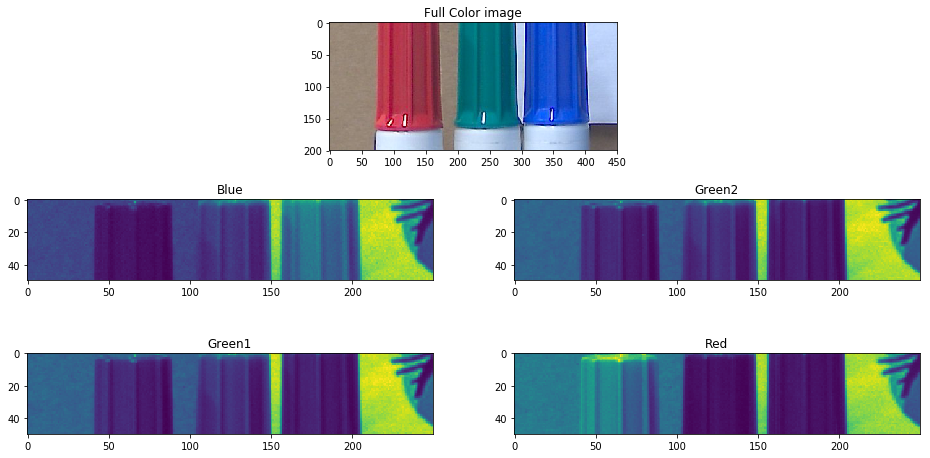

In [9]:
plt.subplot(3, 1, 1)
plt.imshow(jIm[1900:2100, 800:1250])
plt.title('Full Color image')
plt.subplot(3, 2, 3)
plt.imshow(blue[950:1000, 400:650])
plt.title('Blue')
plt.subplot(3, 2, 4)
plt.imshow(green2[950:1000, 400:650])
plt.title('Green2')
plt.subplot(3, 2, 5)
plt.title('Green1')
plt.imshow(green1[950:1000, 400:650])
plt.subplot(3, 2, 6)
plt.imshow(red[950:1000, 400:650])
plt.title('Red')


It can be seen in these how the color channels were infact extracted correctly: the blue marker only lights up in th blue channel, and the red marker only lights up in the red channel.

## Display the channels to compare them: 

Text(0.5, 1.0, 'Red')

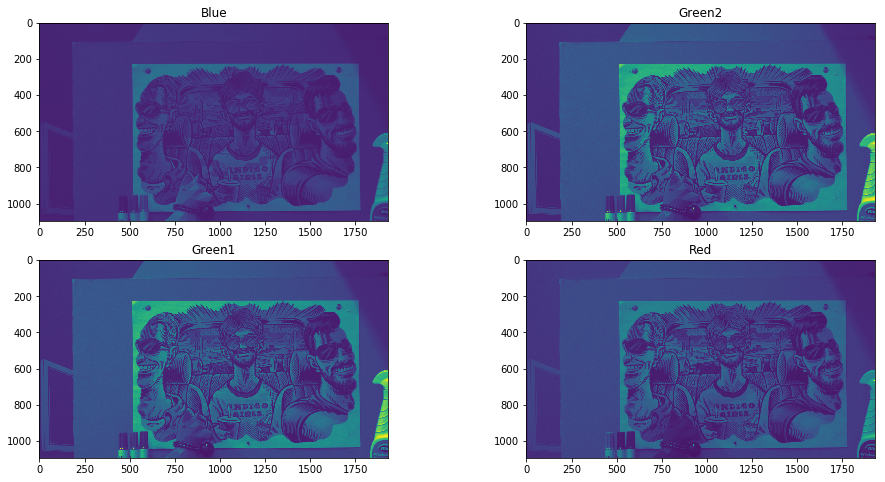

In [10]:
plt.subplot(2, 2, 1)
plt.imshow(blue)
plt.title('Blue')
plt.subplot(2, 2, 2)
plt.imshow(green2)
plt.title('Green2')
plt.subplot(2, 2, 3)
plt.title('Green1')
plt.imshow(green1)
plt.subplot(2, 2, 4)
plt.imshow(red)
plt.title('Red')

The first thing to observe from these images is that the blue component of the image is the dimmest, which goes to show that either the scene is mostly composed by larger wavelength colors, or the camera is least sensitive to blue. 
Another noticeable feature in this image is that the white color in the Gile fluid container appears more bright in the green channels, even though it is supposed look more or less even for all channels. This suggests that the camera is more sensitive to green pixels, which can be corrected for in color adjustment.

# PART 2: Develop our own Demosaicking and Color Adjustment

In [11]:
def shifted_sigmoid(x):
    return 1/(1+np.exp(-x)) - 0.5

In [12]:
def adjustColor(inputImage, rc = 1, bc = 1, gc = 1, gain = 1):
    fI = inputImage.astype(np.float)
    fI[:, :, 0] = rc * fI[:, :, 0]
    fI[:, :, 1] = gc * fI[:, :, 1]
    fI[:, :, 2] = bc * fI[:, :, 2]
    fI=255*np.tanh(gain*fI)
    fI = fI.astype(np.uint8)
    
    return fI


In [13]:
def demosaic(rIm):
    green1 = rIm[1::2, ::2] 
    green2 = rIm[::2, 1::2] 
    red = rIm[1::2, 1::2] 
    blue = rIm[::2, ::2] 
    
    green = (skimage.transform.rescale(green1, 2)+skimage.transform.rescale(green2, 2)) / 2
    red = skimage.transform.rescale(red, 2)
    blue = skimage.transform.rescale(blue, 2)
    
    imageOut = np.dstack((red, green, blue))
    
    return imageOut

/Users/pabloortiz/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/Users/pabloortiz/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/pabloortiz/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


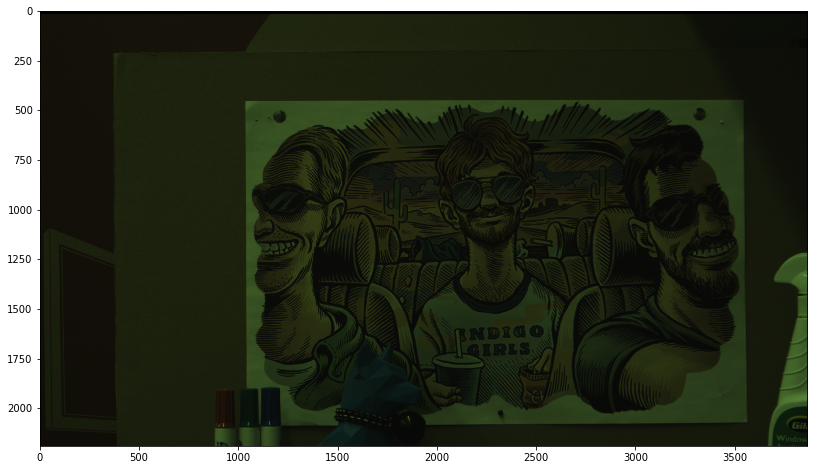

In [14]:
demo = demosaic(rIm)
plt.imshow(demo)

As it can be observed, this image is green heavy. We predicted this earlier by observing how the green channels were more highly valued in the raw bayer data. This can be corrected with the color adjust function written earlier.

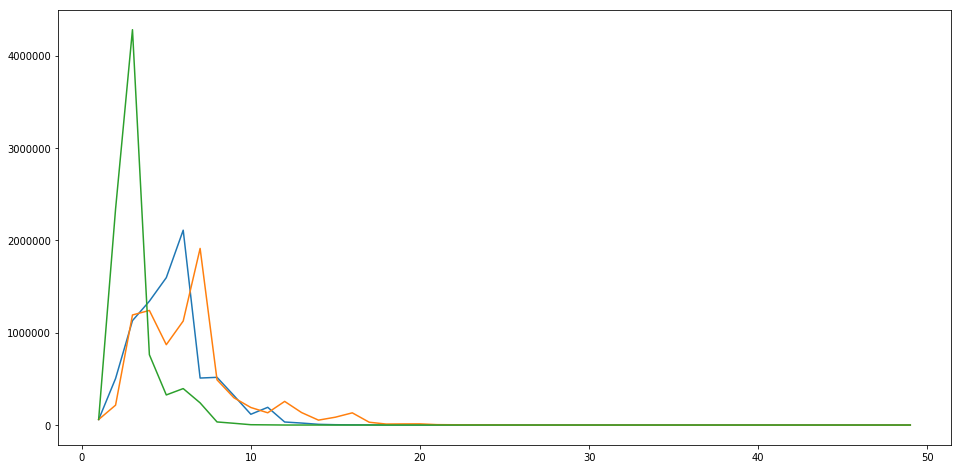

In [15]:
histr, bins = np.histogram(demo[:, :, 0], np.linspace(0, 1))
histg, bins = np.histogram(demo[:, :, 1], np.linspace(0, 1))
histb, bins = np.histogram(demo[:, :, 2], np.linspace(0, 1))
plt.plot(np.arange(1, 50), histr, np.arange(1, 50), histg, np.arange(1, 50), histb)

By observing the histogram we can make some predictions on how the color adjustment should go. For example, it is clear that most of the data is in the lower end of the histogram (for all channels), meaning we need some large gain to improve contrast. Additionally, we can make some rough estimations in that the blue channel needs to be amplified relative to the other two. 

After trying different combinations of parameters, these seemed to yield the best results:

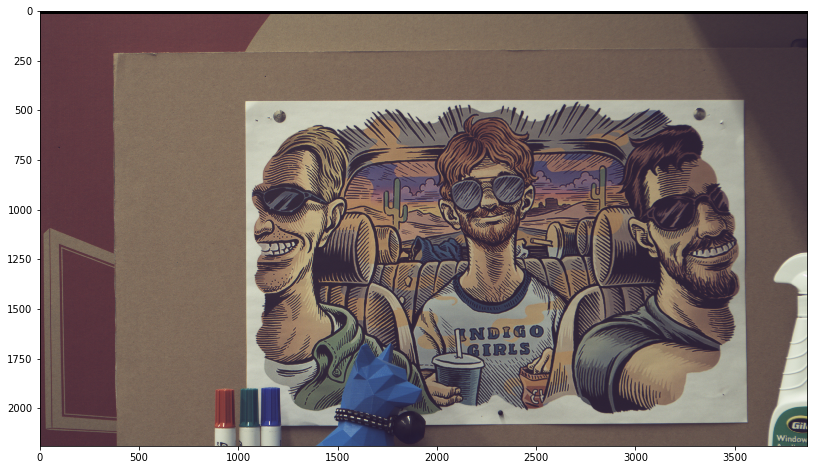

In [16]:
demo_adjust = adjustColor(demo, rc = 1, bc = 1.4, gc = 0.7, gain = 5)
plt.imshow(demo_adjust)

# PART 3: Develop a neural network to train demosaicking in 

### Download the Kodak images

Go through the Kodak image set and add them to a list containing the 64x64 patches from all of them to use for later training.

In [17]:
path_name = r'KodakImages' 
if not os.path.exists(path_name):
    os.makedirs(path_name)
    
set_ground_truth = np.zeros([2304, 64, 64, 3])
patch_num = 0

for i in range(1, 25):
    url_name = "http://r0k.us/graphics/kodak/kodak/kodim" + f"{i:02d}" + ".png"
    file_name = path_name + "/kodim" + f"{i:02d}" + ".png"
    urllib.request.urlretrieve(url_name, file_name)
    a = imio.imread(file_name)
    for row in range(int(a.shape[0] / 64)):
        for col in range (int(a.shape[1] / 64)):
            patch = a[64*row : 64*row + 64, 64*col : 64*col + 64, :]
            set_ground_truth[patch_num, :, :, :] = patch
            patch_num += 1

For a proof of sanity, I make sure the R, G, and B channels correspond to the 0, 1, and 2 channels from the output of imio.imread. The image shown below shows how the first (0) channel brights up more in red. 
The images in the bottom row, it can be observed that the green trees light up more in the second (1) array of the image. this corresponds to the labels, so the RGB are stored as 0,1,2 correspondingly.

Text(0.5, 1.0, 'Full Color')

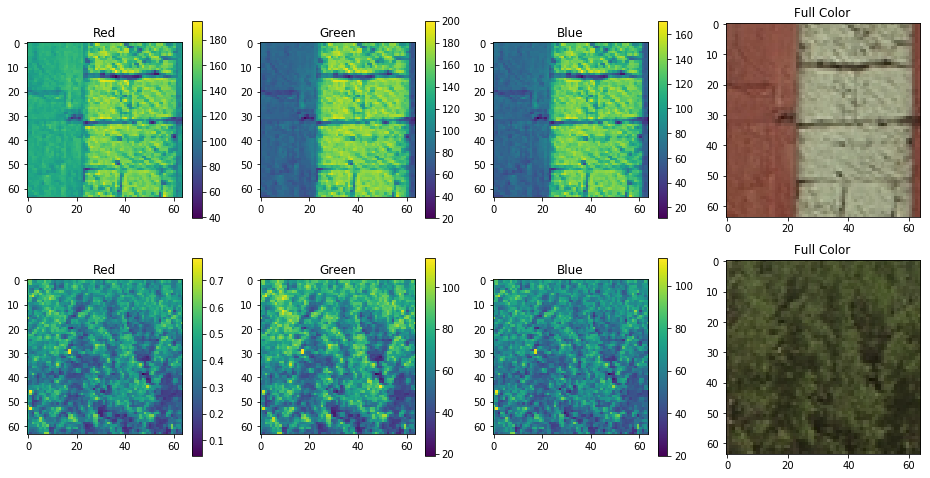

In [18]:
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
a = set_ground_truth[14, :, :, :]
plt.subplot(2,4,1)
plt.imshow(a[:, :, 0])
plt.title('Red')
plt.colorbar()
plt.subplot(2,4,2)
plt.imshow(a[:, :, 1])
plt.title('Green')
plt.colorbar()
plt.subplot(2,4,3)
plt.imshow(a[:, :, 2])
plt.title('Blue')
plt.colorbar()
plt.subplot(2,4,4)
plt.imshow(a[:, :, :] / 255)
plt.title('Full Color')

a = set_ground_truth[1186, :, :, :]
plt.subplot(2,4,5)
plt.title('Red')
plt.colorbar()
plt.imshow(a[:, :, 0])
plt.subplot(2,4,6)
plt.title('Green')
plt.colorbar()
plt.imshow(a[:, :, 1])
plt.subplot(2,4,7)
plt.title('Blue')
plt.colorbar()
plt.imshow(a[:, :, 2])
plt.subplot(2,4,8)
plt.imshow(a[:, :, :] / 255)
plt.title('Full Color')


Now we generate the virtual raw data from the training set by simulating the bayer process simply by downsampling each patches color channel by 4. I just find the raw bayer data by finding the corresponding pixel's value in the true image. I am aware that this ignores the intrinsic blurring that happens in the pixel function for a camera, so I believe downsampling with a kernel is better than picking static values. However, the image processing seemed just a little more complicated than necessary for that, and is not really the point of this HW.. So I demosaic by matching the pixel value for each point to the corresponding pixel in the appropriate channel information from the 'Ground Truth'.

In [19]:
def mosaic(RGB):
    raw_sim = np.zeros_like(RGB[:, :, 0])
    raw_sim[::2, ::2] = RGB[::2, ::2, 2]
    raw_sim[1::2, ::2] = RGB[1::2, ::2, 1]
    raw_sim[::2, 1::2] = RGB[::2, 1::2, 1]
    raw_sim[1::2, 1::2] = RGB[1::2, 1::2, 0]
        
    return  raw_sim

In [20]:
set_raw = np.zeros([2304, 64, 64])
for i in range(2304):
    image = set_ground_truth[i, :, :, :]
    set_raw[i, :, :] = mosaic(image)

For proof of sanity that this function is correctly mosaic I observe the red section of the image to make sure it is not in a diagonal pattern of high intensity and that the upperleftmost pixel is red (lit up). I also want to observe that in the green image, a diagonal pattern is in fact observed:

Text(0.5, 1.0, 'Full Color')

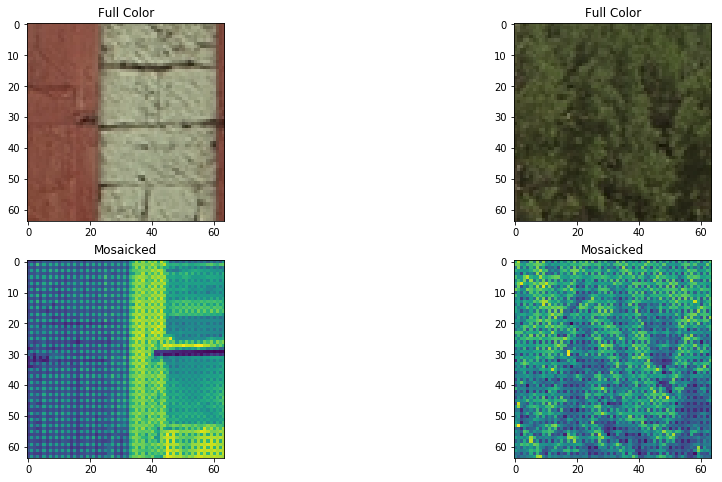

In [21]:
a, b = set_raw[15, :, :], set_raw[1186, :, :], 
plt.subplot(2,2,3)
plt.imshow(a)
plt.title('Mosaicked')
plt.subplot(2,2,4)
plt.imshow(b)
plt.title('Mosaicked')
plt.subplot(2,2,1)

a = set_ground_truth[14, :, :, :]
plt.imshow(a[:, :, :] / 255)
plt.title('Full Color')
plt.subplot(2,2,2)
a = set_ground_truth[1186, :, :, :]
plt.imshow(a[:, :, :] / 255)
plt.title('Full Color')


### Now that our training data is ready... We proceed to the fun part... The neural network!

First, we will want to split our data set into training and validation. We won't have test data here since our test will be run in the tegra camera

In [22]:
percent_validation = 0.3
validation_raw = set_raw[:round(set_raw.shape[0]*percent_validation), :, :]
validation_ground_truth = set_ground_truth[ :round(set_raw.shape[0]*percent_validation), :, :, :]
train_raw = set_raw[round(set_raw.shape[0]*percent_validation):, :, :]
train_ground_truth = set_ground_truth[round(set_raw.shape[0]*percent_validation):, :, :, :]
print("Train size: %d" % train_raw.shape[0])
print("Validation size: %d" % validation_raw.shape[0])

Train size: 1613
Validation size: 691


#### Convert data to list of numpy arrays:

In [23]:
def ground_truth_tolist(x):
    a = []
    for i in range(x.shape[3]):
        a.append(x[i, :, :, :])
    return a

def raw_tolist(x):
    a = []
    for i in range(x.shape[2]):
        a.append(x[i, :, :])
    return a
x_train = raw_tolist(train_raw)
x_test = raw_tolist(validation_raw)
y_train = ground_truth_tolist(train_ground_truth)
y_test = ground_truth_tolist(validation_ground_truth)

In [24]:
def MtoF0(M):
    B = M[:, ::2, ::2]
    G1 = M[:, 1::2, ::2]
    G2 = M[:, ::2, 1::2]
    R = M[:, 1::2, 1::2]
    F0 = K.stack((B, G1, G2, R), axis = 3)
    
    return F0

In [25]:
def FDtoFD1(tensors, batch_size = batch_size):
    M = tensors[1]
    FD = tensors[0]
    
    B = M[:, ::2, ::2]
    G1 = M[:, 1::2, ::2]
    G2 = M[:, ::2, 1::2]
    R = M[:, 1::2, 1::2]
    F0 = K.stack((B, G1, G2, R), axis = 3)
#     F0 = MtoF0(M)
    
    bmask = np.zeros([64, 64])
    g1mask = np.zeros([64, 64])
    g2mask = np.zeros([64, 64])
    rmask = np.zeros([64, 64])
    
    bmask[::2, ::2] = np.ones([32, 32])
    g1mask[1::2, ::2] = np.ones([32, 32])
    g2mask[::2, 1::2] = np.ones([32, 32])
    rmask[1::2, 1::2] = np.ones([32, 32])

    bmask = K.variable(bmask)
    g1mask = K.variable(g1mask)
    g2mask = K.variable(g2mask)
    rmask = K.variable(rmask)
    
    expand = Lambda(lambda x: K.expand_dims(x, axis = -1))
    squeeze = Lambda(lambda x: K.squeeze(x, -1))
    
    x1 = expand(F0[:, :, :, 0])
    bFD1 = UpSampling2D(size = (2, 2))(x1)
    bFD1 = squeeze(bFD1)
    bFD1 = bFD1 * bmask
    
    x1 = expand(F0[:, :, :, 1])
    g1FD1 = UpSampling2D(size = (2, 2))(x1)
    g1FD1 = squeeze(g1FD1)
    g1FD1 = g1FD1 * g1mask
    
    x1 = expand(F0[:, :, :, 2])
    g2FD1 = UpSampling2D(size = (2, 2))(x1)
    g2FD1 = squeeze(g2FD1)
    g2FD1 = g2FD1 * g2mask
    
    x1 = expand(F0[:, :, :, 3])
    rFD1 = UpSampling2D(size = (2, 2))(x1)
    rFD1 = squeeze(rFD1)
    rFD1 = rFD1 * rmask
    
    gFD1 = Add()([g1FD1, g2FD1])

    for i in range(12):
        if np.mod(i, 4) == 0:
            msk = bmask
        elif np.mod(i, 4) == 1:
            msk = g1mask
        elif np.mod(i, 4) == 2:
            msk = g2mask
        else:
            msk = rmask
            
        img = FD[:, :, :, i]
        x1 = expand(img)
        x2 = UpSampling2D(size = (2, 2))(x1)
        out1 = squeeze(x2)
        out2 = out1 * msk
        
        if i < 4:
            if np.mod(i, 4) ==0:
                FDB = out2
            else:
                FDB = Add()([FDB, out2])
        elif i < 8:
            if np.mod(i, 4) == 0:
                FDG = out2
            else:
                FDG = Add()([FDG, out2])
        elif i < 12:
            if np.mod(i, 4) == 0:
                FDR = out2
            else:
                FDR = Add()([FDR, out2])
    FD1 = Concatenate(axis = -1)([expand(bFD1), expand(gFD1), expand(rFD1), expand(FDB), expand(FDG), expand(FDR)])
    return FD1

In [26]:
def base_model():
    img = Input(shape = (64, 64))
    x1 = Lambda(MtoF0)(img)
    x2 = Conv2D(64, (k,k), padding = 'same', activation = 'relu')(x1)
    for i in range(D - 2):
        x2 = Conv2D(64, (k,k), padding = 'same', activation = 'relu')(x2)
    x3 = Conv2D(12, (k,k), padding = 'same', activation = 'relu')(x2)
    x4 = Lambda(FDtoFD1)([x3, img])
    x5 = Conv2D(64, (k,k), padding = 'same', activation = 'relu')(x4)
    x6 = Dense(3)(x5)
    model = Model(input = img, output = x6)
    
    model.compile(loss = 'mse', optimizer = 'adam')
    
    return model
cnn_n = base_model()
cnn_n.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32, 32, 4)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   2368        lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/Users/pabloortiz/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


We don't want to train our model each time we run this, obviously. So the next cell gives flexibility in that it looks for an existing model, and if it doesn't find one, it trains. If it does find it, either it loads it, or overwrites it, depending on the user.

In [27]:
overwrite = True
pop = subprocess.run("bash -c 'ls'", stdout = subprocess.PIPE, shell = True)
rePop = pop.stdout
rePop = rePop.decode('utf-8')
fileName = re.search('trained_model.h5', rePop)
if fileName is not None: 
    if overwrite:
        cnn = cnn_n.fit(train_raw, train_ground_truth, batch_size = batch_size, epochs = epochs, validation_data = (validation_raw, validation_ground_truth), shuffle = True)
#         cnn_n.save('trained_model.h5')
        cnn_n.save_weights('trained_weights.h5')
        overwrite = False
    else: 
#         cnn_n = load_model('trained_model.h5')
        cnn_n.load_weights('trained_weights.h5') 
#         cnn = cnn_n.history
        
else:
    cnn = cnn_n.fit(train_raw, train_ground_truth, batch_size = batch_size, epochs = epochs, validation_data = (validation_raw, validation_ground_truth), shuffle = True)
    cnn_n.save('trained_model.h5')
    cnn_n.save_weights('trained_weights.h5')
    overwrite = False


Train on 1613 samples, validate on 691 samples
Epoch 1/20
1613/1613 [==============================] - 149s 93ms/step - loss: 8396.3818 - val_loss: 1529.0319
Epoch 2/20
1613/1613 [==============================] - 134s 83ms/step - loss: 973.0208 - val_loss: 797.7509
Epoch 3/20
1613/1613 [==============================] - 117s 72ms/step - loss: 494.0044 - val_loss: 588.8159
Epoch 4/20
1613/1613 [==============================] - 109s 68ms/step - loss: 380.8700 - val_loss: 436.9643
Epoch 5/20
1613/1613 [==============================] - 111s 69ms/step - loss: 301.4017 - val_loss: 318.8343
Epoch 6/20
1613/1613 [==============================] - 115s 72ms/step - loss: 240.6882 - val_loss: 239.7280
Epoch 7/20
1613/1613 [==============================] - 114s 70ms/step - loss: 201.0231 - val_loss: 201.1407
Epoch 8/20
1613/1613 [==============================] - 115s 72ms/step - loss: 170.0656 - val_loss: 170.8179
Epoch 9/20
1613/1613 [==============================] - 109s 68ms/step - loss: 

To make things a little more flexible in terms of image input and some pre-processing for images >64x64 dimension I will write a function that does preprocessing to images and then feeds them to the model and returns the values from the model.

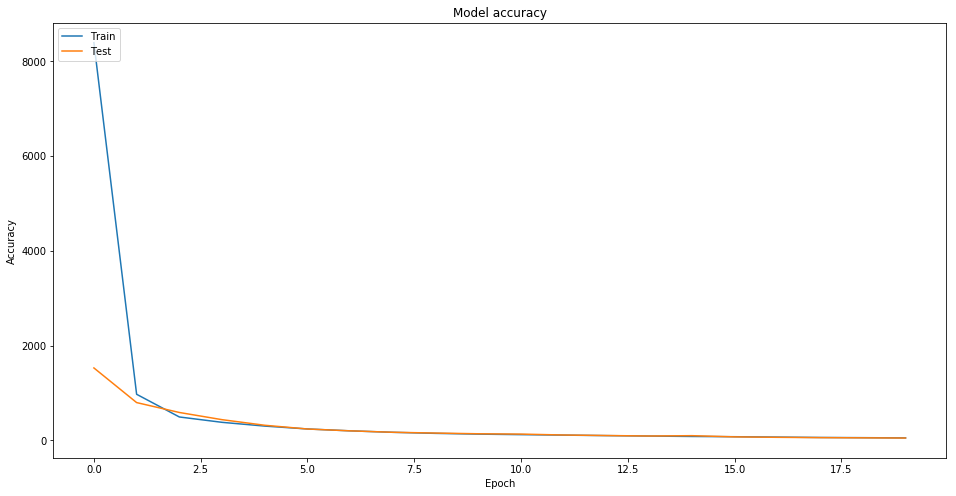

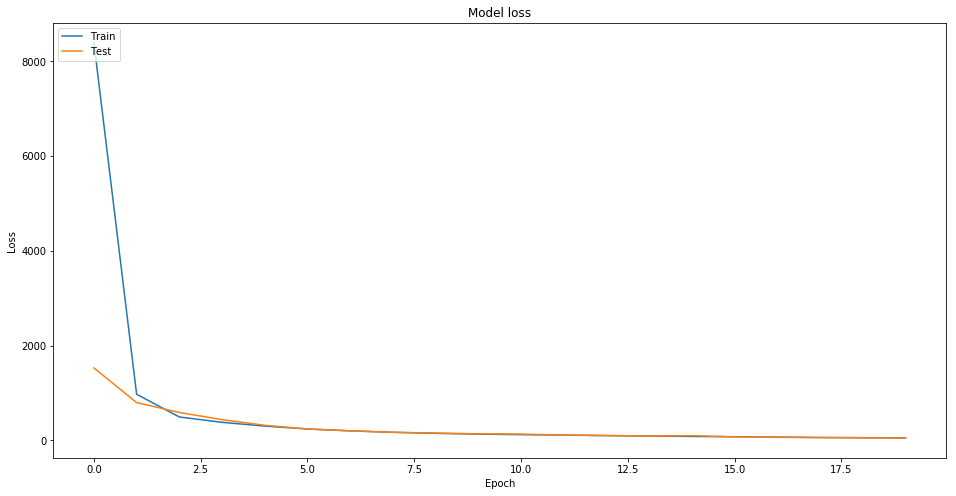

In [28]:
# Plot training & validation accuracy values
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [29]:
def deep_demosaick(img):
    img = 255 * (img / img.max())
    if img.ndim == 2:
        img = img[None, :, :]
    if np.mod(img.shape[1], 64) != 0:
        # Crop the image!
        new_rows = img.shape[1] - np.mod(img.shape[1], 64)
        img = img[:, :new_rows, :]
    if np.mod(img.shape[2], 64) != 0:
        # Crop the image!
        new_cols = img.shape[2] - np.mod(img.shape[2], 64)
        img = img[:, :, :new_cols]
    
    demo = np.zeros((img.shape[0], img.shape[1], img.shape[2], 3))
    for row_patch in range(int(img.shape[1] / 64)):
        for col_patch in range(int(img.shape[2] / 64)):
            img_patch = img[:, row_patch*64 : row_patch*64 + 64, col_patch*64 : col_patch*64 + 64]
            patch = cnn_n.predict(img_patch)
            demo[:, row_patch*64 : row_patch*64 + 64, col_patch*64 : col_patch*64 + 64, :] = patch
    np.clip(demo, 0, 255, out = demo)
    return demo

### Now is time to compare the results from the deep demosaicking and my earlier linear method

Since the deep demosaicking only works for patches of 64x64, I will generate a function that expands it so we can actually demonstrate it..

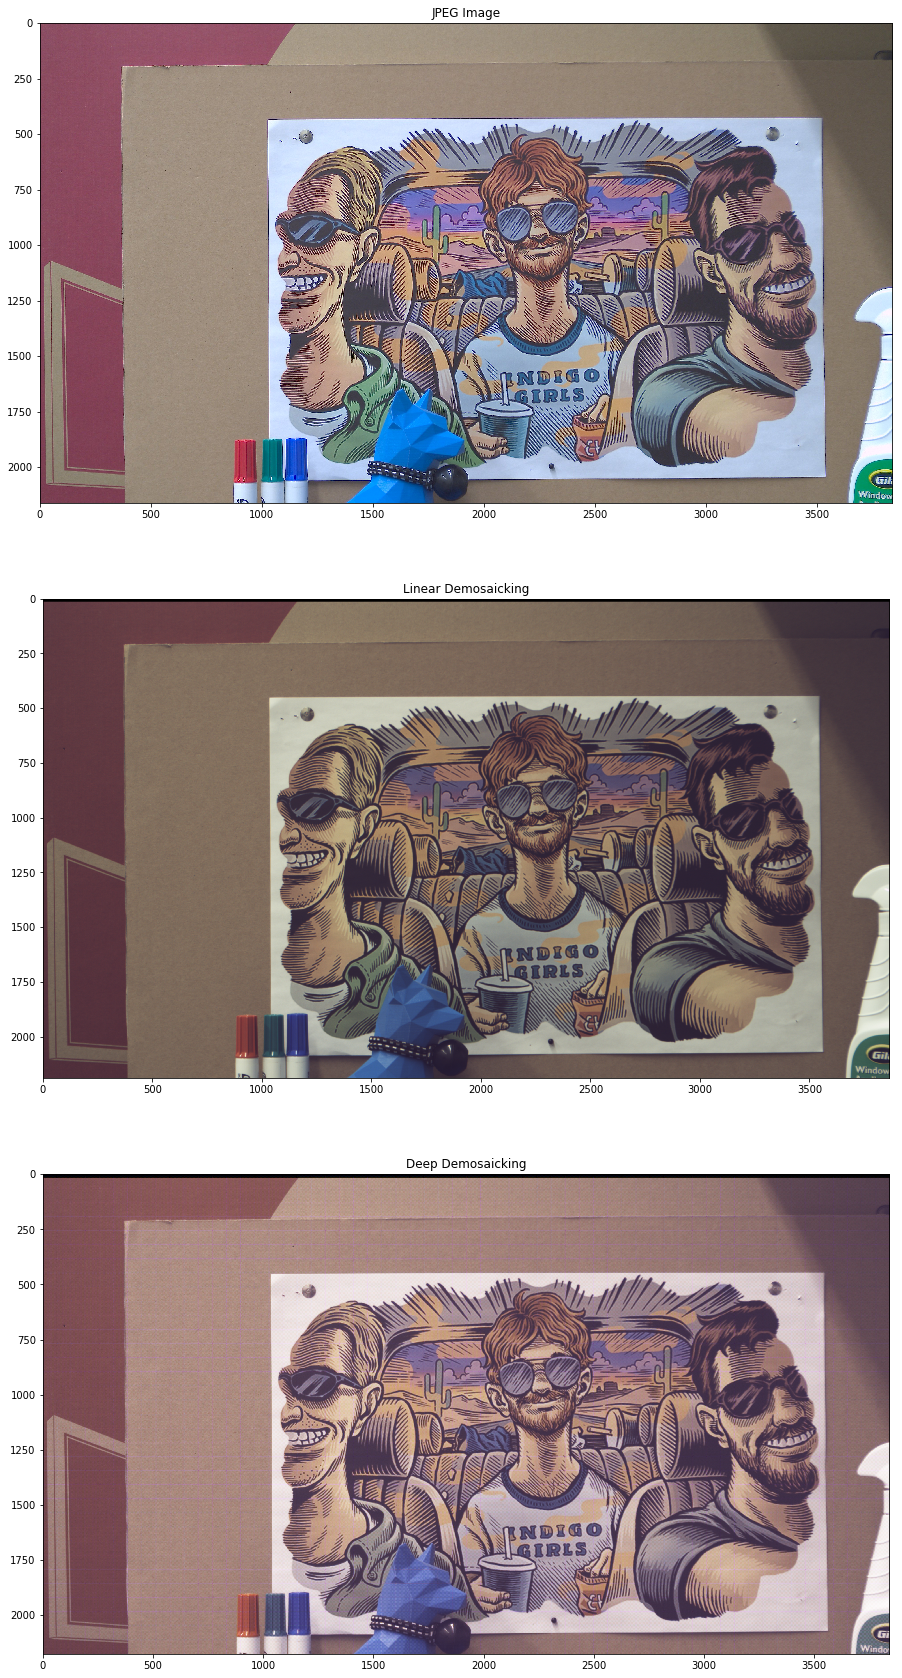

In [30]:
mpl.rcParams['figure.figsize'] = (40.0, 30.0)

deep_dem = deep_demosaick(rIm)
a = adjustColor(deep_dem[0] / 255, rc = 1, bc = 1.4, gc = 0.7, gain = 3.5)
plt.subplot(3, 1, 1)
plt.imshow(jIm)
plt.title('JPEG Image')
plt.subplot(3, 1, 2)
plt.title('Linear Demosaicking')
plt.imshow(demo_adjust)
plt.subplot(3, 1, 3)
plt.title('Deep Demosaicking')
plt.imshow(a)

To be honest, it's very hard to tell any difference in performance between the linear and deep demosaicking methods: other than some color grided artifacts that can be observed in the deep method--likely at the edges of each 64x64 the image was actually processed in.
I'll try zooming in to see any observable differences:

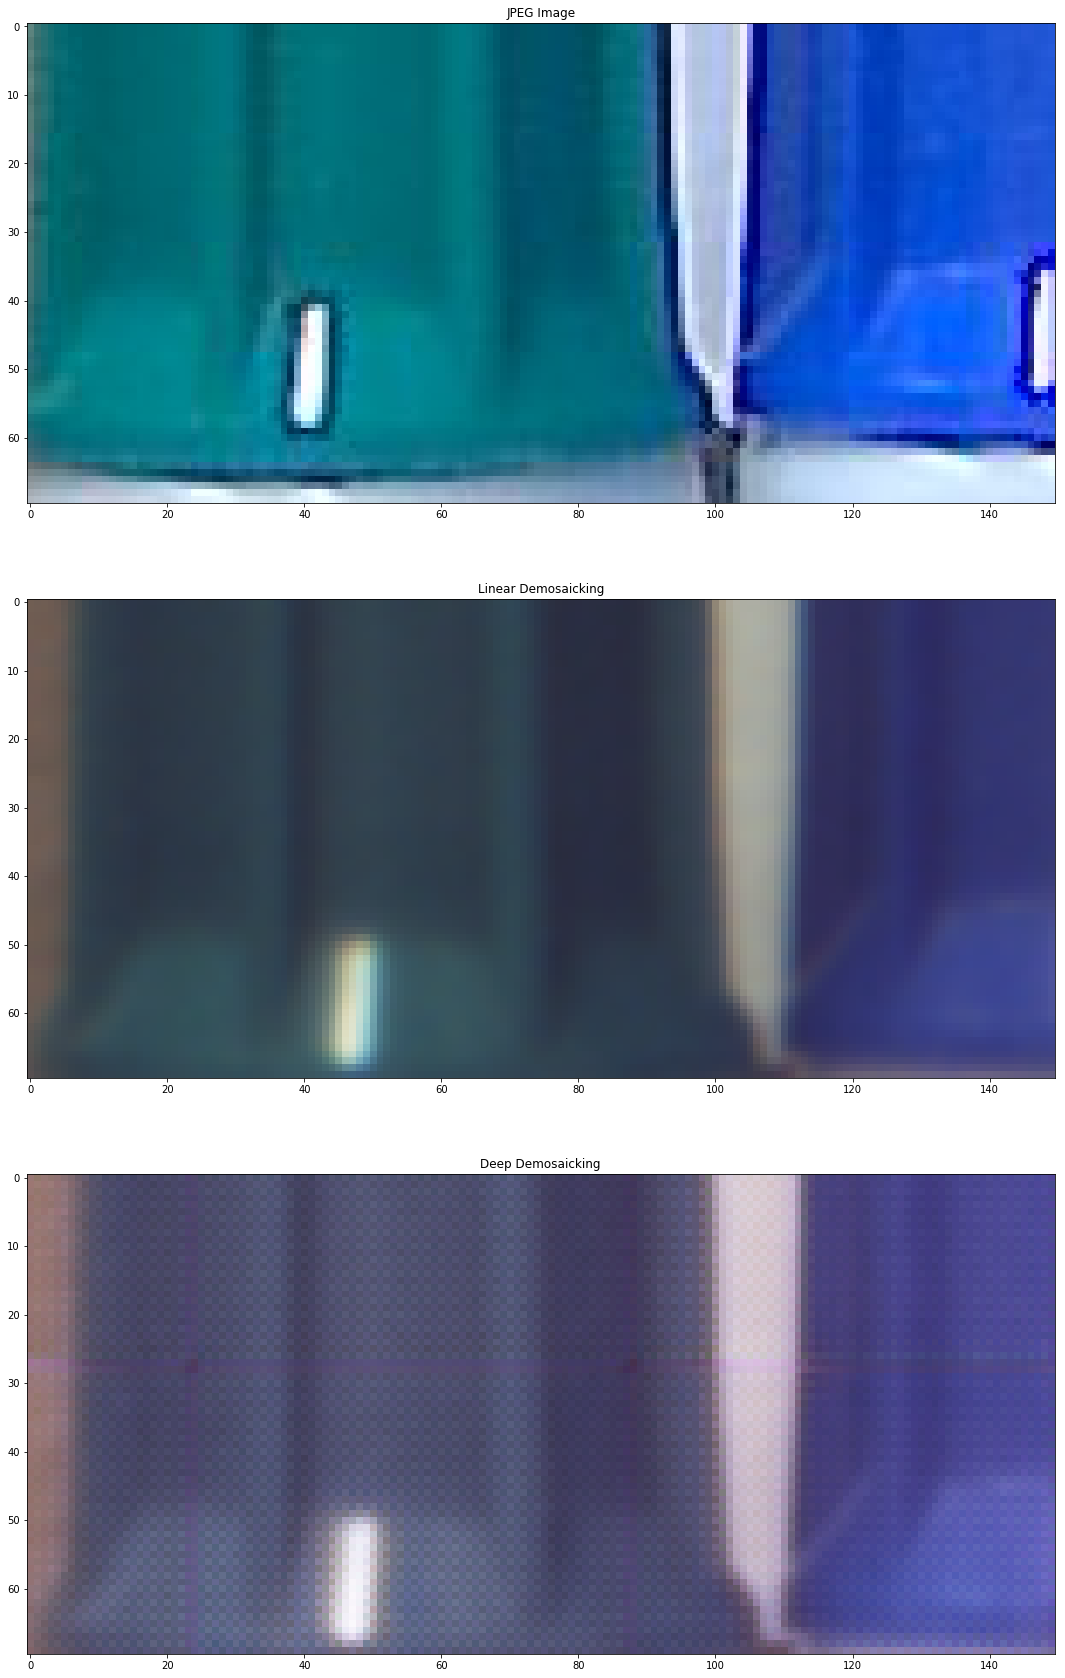

In [31]:
mpl.rcParams['figure.figsize'] = (40.0, 30.0)

plt.subplot(3, 1, 1)
plt.imshow(jIm[2000:2070, 1000:1150, :])
plt.title('JPEG Image')
plt.subplot(3, 1, 2)
plt.title('Linear Demosaicking')
plt.imshow(demo_adjust[2020:2090, 1000:1150, :])
plt.subplot(3, 1, 3)
plt.title('Deep Demosaicking')
plt.imshow(a[2020:2090, 1000:1150, :])

At this zoom you can more easily observe the grided artifact mentioned earlier. Other than that artifact, it's still very hard to tell the difference between the quality in the deep and linear demosaicking. They both, however, seem to perform better than whatever method the camera uses to generate it's own JPEG. 